# 7 一般化線形混合モデル (GLMM) -個体差のモデリング-

In [1]:
using CSV
using DataFrames
using Distributions
using GLM
using LaTeXStrings
using LinearAlgebra
using Plots
using QuadGK
using StatsBase
using Statistics
using MixedModels

## 7.1 例題 : GLMでは説明できないカウントデータ

In [2]:
df = CSV.read("data.csv");

In [3]:
df.N = convert(Array{Float64}, df.N)
df.yy = df.y ./ df.N
disallowmissing!(df)

,N,y,x,id,yy
,Float64,Int64,Int64,Int64,Float64
1,8.0,0,2,1,0.0
2,8.0,1,2,2,0.125
3,8.0,2,2,3,0.25
4,8.0,4,2,4,0.5
5,8.0,1,2,5,0.125
6,8.0,0,2,6,0.0
7,8.0,0,2,7,0.0
8,8.0,7,2,8,0.875
9,8.0,1,2,9,0.125


### データの図示  
個体数をマーカーの大きさに反映させている  
破線は「真の」生存確率の一例

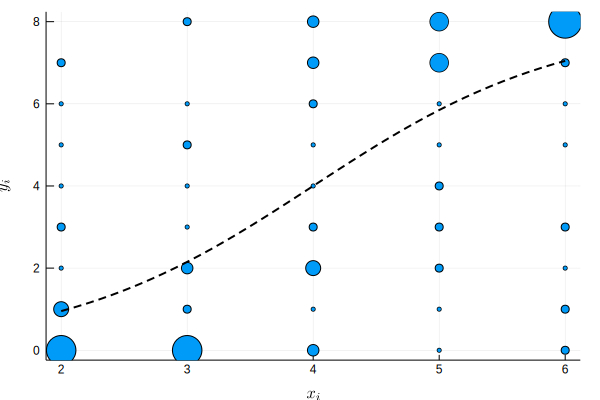

In [4]:
xs = 2:0.1:6
df_plot = aggregate(df, [:x, :y], length)
scatter(df_plot.x, df_plot.y, markersize=df_plot.id_length .* 2, label="")
plot!(xs, mean.(Binomial.(8, logistic.(-4 .+ 1 .* xs))), label="",
    xlabel=L"x_i", ylabel=L"y_i",
    linestyle=:dash, linewidth=2, linecolor = :black)

### GLMを使ってデータから種子の生存確率を推定

In [5]:
glm_model = glm(@formula(yy ~ x), df, Binomial(), wts=df.N)

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: yy ~ 1 + x

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -2.14874  0.237235 -9.05744   <1e-18
x            0.510381 0.0556032  9.17898   <1e-19


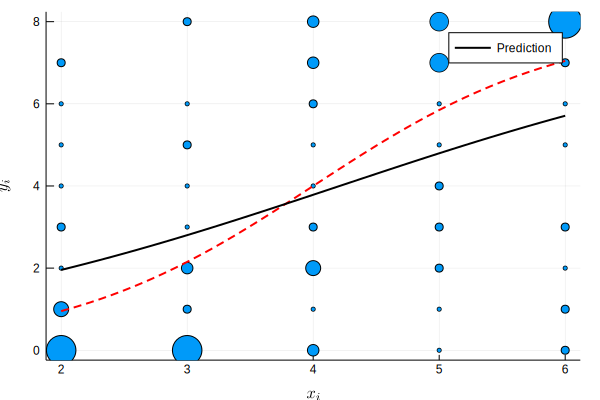

In [6]:
scatter(df_plot.x, df_plot.y, markersize=df_plot.id_length .* 2, label="",
    xlabel=L"x_i", ylabel=L"y_i")
plot!(xs, mean.(Binomial.(8, logistic.(-4 .+ 1 .* xs))), label="",
    linestyle=:dash, linewidth=2, linecolor = :red)
xx = DataFrame(x=xs)
plot!(xs, predict(glm_model, xx) .* 8, label="Prediction", linewidth=2, linecolor = :black)

### 葉数が4となるデータのサブセットを作る

In [7]:
d4 = df[df.x .== 4, :]

,N,y,x,id,yy
,Float64,Int64,Int64,Int64,Float64
1,8.0,6,4,41,0.75
2,8.0,2,4,42,0.25
3,8.0,0,4,43,0.0
4,8.0,5,4,44,0.625
5,8.0,6,4,45,0.75
6,8.0,2,4,46,0.25
7,8.0,8,4,47,1.0
8,8.0,2,4,48,0.25
9,8.0,7,4,49,0.875


In [8]:
d4_plot = aggregate(d4, [:x, :y], length)

,x,y,N_length,id_length,yy_length
,Int64,Int64,Int64,Int64,Int64
1,4,6,2,2,2
2,4,2,4,4,4
3,4,0,3,3,3
4,4,5,1,1,1
5,4,8,3,3,3
6,4,7,3,3,3
7,4,4,1,1,1
8,4,3,2,2,2
9,4,1,1,1,1


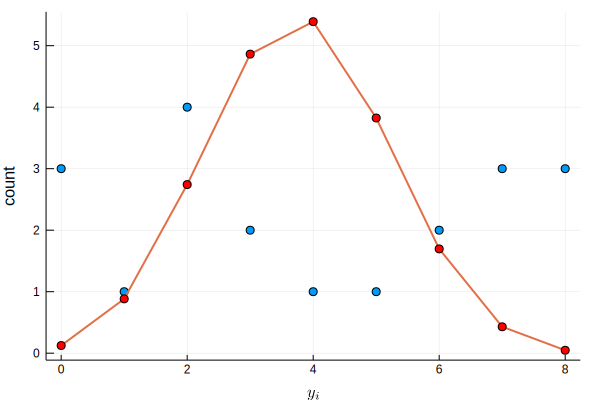

In [9]:
xs4 = 0:8
ys4 = pdf.(Binomial(8, 0.47), xs4) * 20
scatter(d4_plot.y, d4_plot.id_length, label="",
    xlabel=L"y_i", ylabel="count")
plot!(xs4, ys4, linewidth=2, label="")
scatter!(xs4, ys4, label="", markercolor="red")

## 7.2 過分散と個体差
### 7.2.1 過分散 : ばらつきが大きすぎる

生存数ごとにカウントする

In [10]:
sort(countmap(d4.y))

OrderedCollections.OrderedDict{Int64,Int64} with 9 entries:
  0 => 3
  1 => 1
  2 => 4
  3 => 2
  4 => 1
  5 => 1
  6 => 2
  7 => 3
  8 => 3

データの平均と分散を調べる

In [11]:
mean(d4.y), var(d4.y)

(4.05, 8.36578947368421)

### 7.4.1 Juliaを使ってGLMMのパラメーターを推定
MixedModels.jlを使う  
http://dmbates.github.io/MixedModels.jl/latest/index.html

フィッティング結果は本文のものとは少し異なる。  
$\hat{\beta}_1 = -4.19, \hat{\beta}_2 = 1.00, \hat{s}=2.41,$ residual deviance $=269.$

In [12]:
glmm_model = fit!(GeneralizedLinearMixedModel(@formula(yy ~ x + (1 | id)), df, Binomial(), wt=df.N))

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  Formula: yy ~ x + (1 | id)
  Distribution: Binomial{Float64}
  Link: LogitLink()

  Deviance: 269.4142

Variance components:
        Column    Variance  Std.Dev. 
 id (Intercept)  5.7991165 2.4081355

 Number of obs: 100; levels of grouping factors: 100

Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   -4.1899  0.827406 -5.0639   <1e-6
x             1.00483  0.195105 5.15021   <1e-6


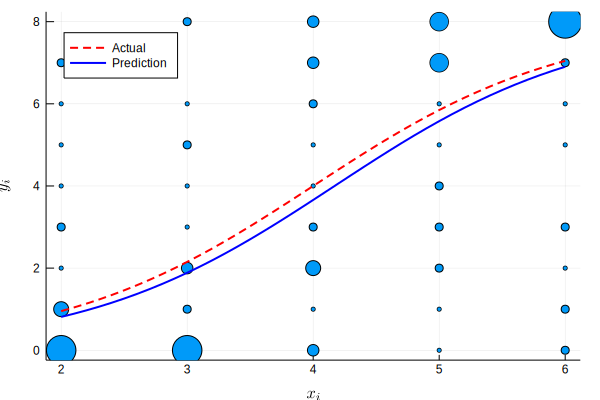

In [13]:
scatter(df_plot.x, df_plot.y, markersize=df_plot.id_length .* 2, label="",
    xlabel=L"x_i", ylabel=L"y_i", legend=:topleft)
plot!(xs, mean.(Binomial.(8, logistic.(-4 .+ 1 .* xs))), 
    label="Actual",
    linestyle=:dash, linewidth=2, linecolor = :red)
plot!(xs, mean.(Binomial.(8, logistic.([fill(1, length(xs)) xs] * coef(glmm_model)))), 
    label="Prediction",linewidth=2, linecolor = :blue)

In [14]:
Binomial(8, logistic(dot([1 4], coef(glmm_model))))

Binomial{Float64}(n=8, p=0.45746080749609197)

### 分布を混ぜる  
http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/hbm/gaussianbinom.R

In [15]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end 

f_gaussian_binorm (generic function with 1 method)

In [16]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

### GLMMから予測された混合二項分布をプロットする

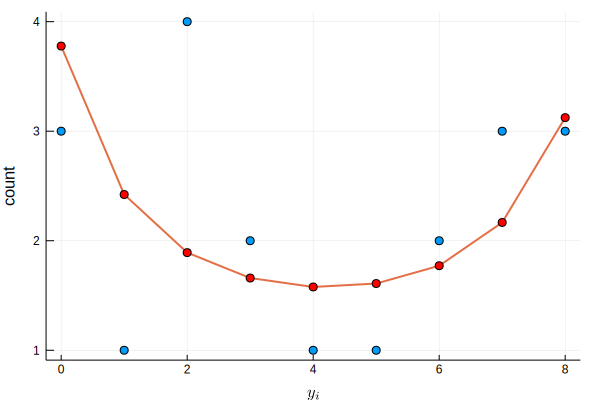

In [17]:
pdf_gaussian_binorm = d_gaussian_binorm.(0:8, dot([1 4], coef(glmm_model)), std(glmm_model)[][])
scatter(d4_plot.y, d4_plot.id_length, label="",
    xlabel=L"y_i", ylabel="count")
plot!(0:8, pdf_gaussian_binorm * 20, linewidth=2, label="")
scatter!(0:8, pdf_gaussian_binorm * 20, label="", markercolor="red")